# Convolutional Neural Networks (CNNs) For Brain Tumor Classification

CNNs are a class of deep neural networks commonly used for analyzing visual imagery. They are particularly effective for image classification and recognition tasks due to their ability to capture spatial hierarchies in images.

### Key Components:

1. **Convolutional Layers**:
   - **Filters/Kernels**: Small matrices that slide over the input data to detect patterns such as edges, textures, or shapes.
   - **Convolution Operation**: The filter is applied to the input data, producing a feature map that highlights the presence of specific features.

2. **Activation Function**:
   - Typically, a non-linear function like ReLU (Rectified Linear Unit) is applied to introduce non-linearity into the model, allowing it to learn complex patterns.

3. **Pooling Layers**:
   - **Max Pooling**: Reduces the spatial dimensions of the feature maps by taking the maximum value in a defined window, helping to make the model invariant to small translations.
   - **Average Pooling**: Similar to max pooling but takes the average value instead.

4. **Flattening**:
   - Converts the 2D feature maps into a 1D vector, preparing it for the fully connected layers.

5. **Fully Connected Layers**:
   - Neurons in these layers are fully connected to all activations in the previous layer, similar to traditional neural networks. They combine the features to predict the final output.

6. **Output Layer**:
   - Uses an activation function like softmax for multi-class classification, providing probabilities for each class.

CNNs have revolutionized the field of computer vision and are widely used in applications such as image and video recognition, medical image analysis, and autonomous vehicles.
### Packages and Imports
We will use packages that help with preprocessing the data and splitting the data into training, testing, and validation sets. Additionally, we will also import `os` to make sure we are in the correct working directory and the `preprocess_data` function from our Preprocessing script. The code below loads everything needed for preprocessing.

In [2]:
import os
from scripts.drafts.Preprocessing import preprocess_data
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Preprocessing
First we have to find the pathway of our current working directory and add the pathways of the raw data files so that we can access them when we do our preprocessing.

In [3]:
# Save pathway to working directory
my_dir = os.getcwd()
print(f"Current working directory: {my_dir}")

# Save pathways of raw data files
glioma_path = my_dir + "/data/glioma_tumor"
meningioma_path = my_dir + "/data/meningioma_tumor"
pituitary_path = my_dir + "/data/pituitary_tumor"
normal_path = my_dir + "/data/normal_tumor"

Current working directory: /Users/caseylinden/Documents/PSTAT197A/GitHub/vignette-cnn


Next we preprocess the raw data in order to train our neural network model. Since there are thousands of images in the raw data, we decided to select 200 images from each category, giving us a total of 800 images. We set a seed for reproducibility as well. 

After pulling our images and labels, we have to ensure that each category has the same shape, or our model will not work.

In [4]:
# preprocess data
n_samples = 200 # good starting point to train model
seed = 42 # reproducibility
glioma_data, glioma_labels = preprocess_data(glioma_path, n_samples, seed)
meningioma_data, meningioma_labels = preprocess_data(meningioma_path, n_samples, seed)
pituitary_data, pituitary_labels = preprocess_data(pituitary_path, n_samples, seed)
normal_data, normal_labels = preprocess_data(normal_path, n_samples, seed)
if glioma_data.shape != meningioma_data.shape or pituitary_data.shape != normal_data.shape:
    raise ValueError("All data must have the same shape")
else:
    print("All data have the same shape")

All data have the same shape


Next we can combine all of our images and their labels into separate arrays. From here we partition our data into training and testing sets. We also created a validation set so that we can test our model accuracy as it is training. The labels must also be one hot encoded so that our model is able to process what category each image falls into.

In [13]:
# combine all data and labels
data = np.concatenate([glioma_data, meningioma_data, pituitary_data, normal_data])
labels = np.concatenate([glioma_labels, meningioma_labels, pituitary_labels, normal_labels])
print(f"Combined data and labels shape: {data.shape}, {labels.shape}")

# split data into training and testing and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
train_small, val_data, train_small_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=42)

# one hot encode labels
label_encoder = OneHotEncoder(sparse_output=False)
train_labels = label_encoder.fit_transform(np.array(train_labels).reshape(-1, 1))
test_labels = label_encoder.transform(np.array(test_labels).reshape(-1, 1))
train_small_labels = label_encoder.transform(np.array(train_small_labels).reshape(-1, 1))
val_labels = label_encoder.transform(np.array(val_labels).reshape(-1, 1))

Combined data and labels shape: (800, 256, 256, 1), (800,)


## Visual Inspection
To make sure that our data was correctly preprocessed and is ready for our model, we will look at it ourselves. We look at the first 9 images from our training set and their corresponding label, making sure that it looks correct. The image shows that an xray of a brain with cancer has a visible lump in it, while a scan of a normal brain does not have any features that particularly stand out.

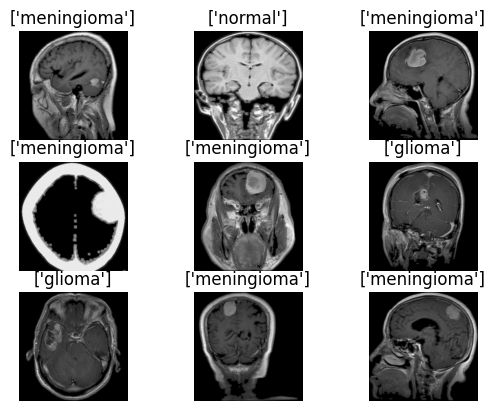

In [6]:
# inverse transform labels
labels = label_encoder.inverse_transform(train_labels)

# show images from training set
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_data[i], cmap="gray")
    plt.axis('off')
    plt.title((labels[i]))
plt.show()

## Modeling
First, we can start with a simple convolution model to see how well a few different architectures will pick up on the training data set. Then we will apply a hyperparameter tuning technique, called Hyperband tuning, to find the best setup for our neural network.

### Import packages
Before we begin modeling, we must import `keras` so that we can build our neural network. We also import a few functions from `keras` so that we can more easily call them later on.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import keras

## Simple CNN to Start
### Model Flow
In our example, the filters will pickup on different shapes, edges, and other patterns in the image, by sliding multiple 3x3 kernels convolving with the input image.

After this we, apply a pooling function of either averaging or maximizing which typically halves the size of our convolved feature.

Then after another two rounds of convolving and maxpool, we flatten it and pass to a Dense neural network of hidden layers.

Finally, the output layer is activated by a softmax function to provide us with probabilities of the classes. 

In [15]:
# Initialize model
model = Sequential()

# Convolutional layer + pooling
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(256, 256, 1))) # 3x3 is the kernel size, 64 is the number of filters
model.add(MaxPooling2D(2))

# Add another convolutional layer + pooling
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(2))

# Add another convolutional layer + pooling
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(2))

# Flatten 3D feature maps into 1D feature vectors
model.add(Flatten())

# Fully connected layer
model.add(Dense(units=128, activation='relu'))

# Dropout to prevent overfitting
model.add(Dropout(0.5))

# Output layer
model.add(Dense(units=4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

# Training the model

We first need to import the EarlyStopping function from TensorFlow's Keras library. **EarlyStopping** is used to monitor a performance metric (in this case accuracy) during training and stop training if that metric doesn't improve, helping prevent overfitting and saving time. 

We then can use the **.fit()** function to train the neural network using the data provided above. 

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
# import clear_session to clear the model from memory
from tensorflow.keras import backend as K
K.clear_session()

# Train the model

# Early stopping will stop training when the validation loss stops improving for a few epochs, preventing overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(
    train_small,
    train_small_labels,
    validation_data=(val_data, val_labels), # Convert sparse matrix
    epochs=20,
    batch_size=32, # number of training samples processed before updating model's weights
    callbacks=[early_stopping]
)

# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/20
15/15 [==============================] - 36s 2s/step - loss: 1.5656 - accuracy: 0.2438 - val_loss: 1.3716 - val_accuracy: 0.1875
Epoch 2/20
15/15 [==============================] - 32s 2s/step - loss: 1.3327 - accuracy: 0.3271 - val_loss: 1.2549 - val_accuracy: 0.4250
Epoch 3/20
15/15 [==============================] - 33s 2s/step - loss: 1.2114 - accuracy: 0.4292 - val_loss: 1.1168 - val_accuracy: 0.6000
Epoch 4/20
15/15 [==============================] - 34s 2s/step - loss: 1.0125 - accuracy: 0.5833 - val_loss: 1.0011 - val_accuracy: 0.5750
Epoch 5/20
15/15 [==============================] - 32s 2s/step - loss: 0.8873 - accuracy: 0.6208 - val_loss: 0.8730 - val_accuracy: 0.6750
Epoch 6/20
15/15 [==============================] - 31s 2s/step - loss: 0.7452 - accuracy: 0.7042 - val_loss: 1.0543 - val_accuracy: 0.5750
Epoch 7/20
15/15 [==============================] - 31s 2s/step - loss: 0.6788 - accuracy: 0.7479 - val_loss: 0.7545 - val_accuracy: 0.7375
Epoch 8/20
15/15 [==

The output from training the CNN shows how the accuracy and loss on the training and validation sets change over time. Additionally, when testing our model on the testing set we achieved an accuracy of about 70% percent. While this model had a simple architecture and only ran for 15 epochs, more complex models run over more epochs will create code outputs that are hard to read. Thus it's better to graph the accuracy and loss values and see how they change as the CNN trains.

## Plotting accuracy and loss

We can then use our model to plot how accuracy and loss change over time in the training and validation sets

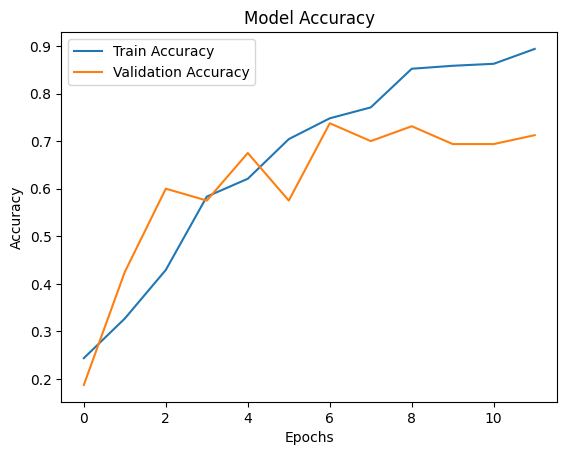

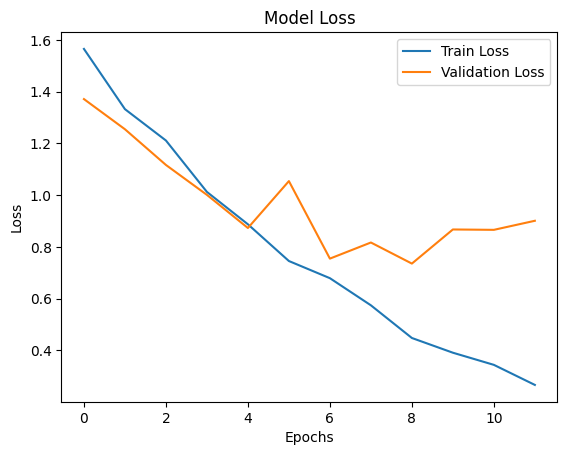

In [17]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Overall the model quickly improves it's accuracy and loss on the training set, which makes sense. However, the plots show that the accuracy of the model faulters a little on the validation set with its best accuracy at epoch six. In addition to the test accuracy of 70%, the waivering accuracy on the validation set suggest this simple CNN architecture isn't a good choice for correctly predicting these photos (after all, you wouldn't want a doctor that can only correctly identify cancer 70% of the time). Thus we continue but experimenting with other CNN architectures and using hyperband tuning to optimize our model and achieve a higher test accuracy.